### Background

All traded assets are illiquid. The bid ask spread, measuring
the difference between the price at which you can buy and sell
the asset at the same point in time is the illiquidity measure.

We can regress the bid-ask spread (as a percent of the
price) against variables that can be measured for a private
firm (such as revenues, cash flow generating capacity, type of
assets, variance in operating income) and are also available for
publicly traded firms.

Using data from the end of 2000, for instance, we regressed the
bid-ask spread against annual revenues, a dummy variable for
positive earnings (DERN: 0 if negative and 1 if positive), cash as
a percent of firm value and trading volume.
    § Spread = 0.145 - 0.0022 ln (Annual Revenues) -0.015 (DERN) - 0.016 (Cash/Firm Value) - 0.11 ($ Monthly trading volume/ Firm Value)
    § You could plug in the values for a private firm into this regression (with zero trading volume) and estimate the spread for the firm.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from download_company import Company, YahooFinance

### How do I use this notebook?

There are 3 determinants of this notebook:
1. `regression_v2.ipynb` (the notebook itself): runs the statistical analysis, visualizations, and models
2. `download_company.py`: downloads company info from Yahoo Finance
3. The file with company symbols (e.g., `nano_usa.csv`): contains the stock symbols to be downloaded

FAQs
1. How do I change which companies are downloaded?
    - A: Download a set of stocks from the NASDAQ website. Refer to the cells below `reuse_results == False`
2. How do I change which company information is used?
    - A: Refer to the names of various info from the Apple sample.
3. How do I avoid re-downloading all company data from Yahoo Finance?
    - A: Set `reuse_results = True` in the cell under 'Inputs to this notebook'

### Inputs to the `download_company.py` script

If you'd like to make edits to which data is used in the model, obtain it similarly to this line:

```python
# Natural log of TTM revenues
ttm_revenues = info['totalRevenue']                 # The `info` object contains company information
ln_revenues = self.get_ln_revenues(ttm_revenues)    # This is a function call to adjust the information retrieved
```

If you'd like to include it in the model, set it on this line:

```python
self.data = {
    'Log Revenues': ln_revenues,
    'DERN': dern,
    'Cash-to-EV': cash_to_ev,
    'Volume-to-EV': vol_to_ev,
    ...
}
```

### Inputs to this notebook
1. Specify `reuse_results` to toggle whether the notebook downloads all data, or reuses an existing Excel file. If you want to avoid running the download, set this to `True`, otherwise, `False`.
2. Specify the name of the stock symbol file in `dataset_name`. It is assumed that an existing dataset has this name, or if the download is run, the newly-created dataset will be saved under this name.

In [ ]:
# Inputs
reuse_results = True
dataset_name = 'nano_usa'

### `reuse_results == True` --> Load existing dataset

In [3]:
df = None
dataset_file = dataset_name + '_dataset.xlsx'

if reuse_results:
    df = pd.read_excel(dataset_file, index_col=0)

### `reuse_results == False` --> Importing Data from NASDAQ Stock Symbols file
1. Go to the NASDAQ website: [NASDAQ](https://www.nasdaq.com/market-activity/stocks/screener)
2. Filter the list of companies
3. Download the list as CSV
4. Rename the file to stocks.csv and add it to this folder

P.S. You can also use any file with stock symbols, as long as it contains a table with a column named 'Symbol' in it.

In [4]:
stock_symbols = None
if not reuse_results:
    stock_symbols_file = dataset_name + '.csv'
    nasdaq_df = pd.read_csv(stock_symbols_file)
    display(nasdaq_df.iloc[:2])

    stock_symbols = nasdaq_df.Symbol
    display(stock_symbols.head())

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,AACB,Artius II Acquisition Inc. Class A Ordinary Sh...,$9.9625,-0.0175,-0.175%,0.0,United States,2025.0,417,NaN,NaN
1,AACBR,Artius II Acquisition Inc. Rights,$0.24,0.0200,9.091%,0.0,United States,2025.0,10898,NaN,NaN


0     AACB
1    AACBR
2    AACBU
3     AAME
4      ABP
Name: Symbol, dtype: object

It is highly likely that most of these symbols will not have the data we need, so hopefully we shoot for the moon and land in the stars. Let's collect all these symbols into a dataset using our helper class:

In [5]:
if not reuse_results:
    # Download required data from companies
    downloader = YahooFinance()

    data = downloader.download_companies(stock_symbols)

    df = pd.DataFrame()
    for ticker, company in data.items():
        df = pd.concat([df, company.get_df()])
df.head()

Error occurred while downloading data for company: AACB
No data exists for 'totalRevenue'

Error occurred while downloading data for company: AACBR
No data exists for 'totalRevenue'

Error occurred while downloading data for company: AACBU
No data exists for 'totalRevenue'

Error occurred while downloading data for company: AAME
AAME has negative or zero ask: 0.0

Error occurred while downloading data for company: ACONW
No data exists for 'enterpriseValue'

Error occurred while downloading data for company: ACRV
No data exists for 'totalRevenue'

Error occurred while downloading data for company: ACXP
No data exists for 'totalRevenue'

Error occurred while downloading data for company: ADD
No data exists for 'revenueGrowth'

Error occurred while downloading data for company: ADIL
No data exists for 'totalRevenue'

Error occurred while downloading data for company: ADNWW
No data exists for 'enterpriseValue'

Error occurred while downloading data for company: ADVWW
No data exists for 'en

,Log Revenues,DERN,Cash-to-EV,Volume-to-EV,Debt-to-EV,Revenue Growth,Return on Assets,Bid-Ask Spread
ABP,12.117241,1.0,0.230766,0.036460,0.269470,-1.000,-1.54706,0.387330
ABVC,13.141360,1.0,0.017082,0.008399,0.174312,-0.092,-0.38380,0.055118
ACCS,16.953480,0.0,0.086014,0.000340,0.356111,-0.227,-0.02137,0.056229
ACON,10.730379,1.0,0.132929,22.213029,0.000000,-0.258,-1.50358,0.542302
ACP,17.913618,1.0,0.002828,0.001448,0.242762,0.848,0.03892,0.014109


Save dataset to Excel file for manual processing

In [6]:
if not reuse_results:
    df.to_excel(dataset_file)

### Statistical Analysis

In [7]:
df.describe()

,Log Revenues,DERN,Cash-to-EV,Volume-to-EV,Debt-to-EV,Revenue Growth,Return on Assets,Bid-Ask Spread
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,16.423454,0.527500,-0.404790,0.386726,0.209184,0.388895,-0.248519,0.176044
std,2.228559,0.499868,3.312930,8.249794,1.876887,3.045842,0.478883,0.264220
min,6.077642,0.000000,-39.263746,-71.003141,-35.309296,-1.000000,-5.970171,0.000923
25%,15.280486,0.000000,0.001462,0.000539,0.007054,-0.223250,-0.365355,0.031466
50%,16.564651,1.000000,0.036662,0.001397,0.253229,-0.014000,-0.102160,0.065163
75%,17.813588,1.000000,0.228783,0.009398,0.615402,0.151750,0.011290,0.135423
max,25.643575,1.000000,6.384709,142.564337,3.519684,52.688000,2.389690,1.818917


Text(0.5, 1.0, 'Pairwise correlation between features')

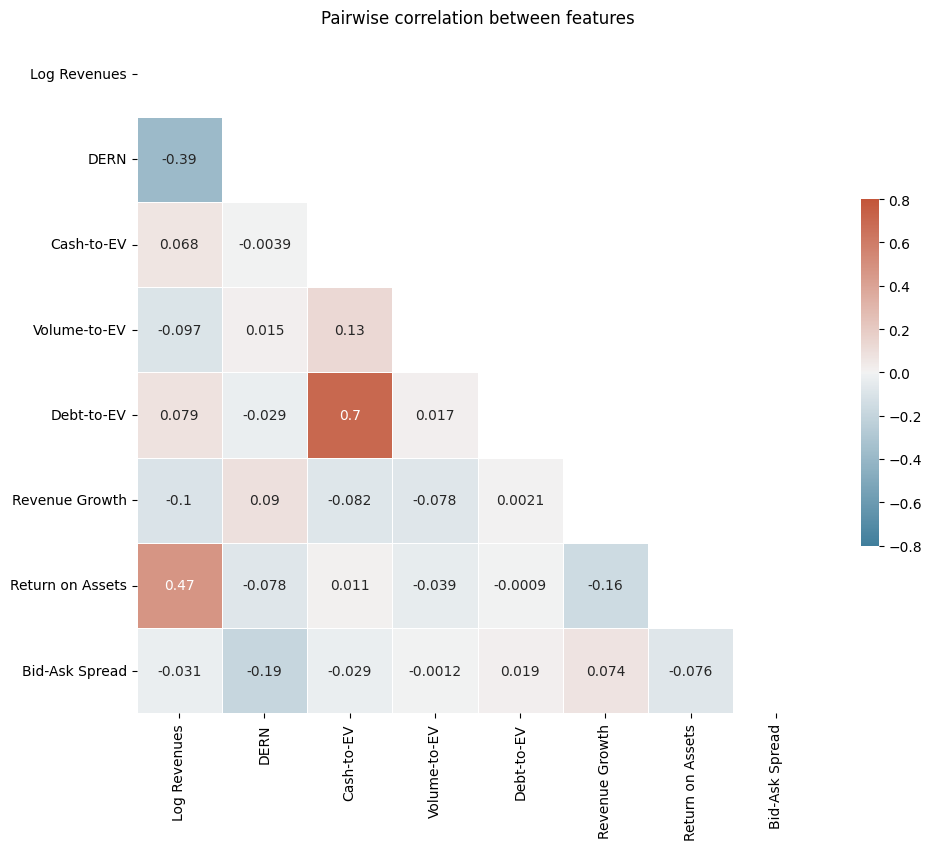

In [8]:
# Get pairwise correlations between features
pairwise_corr = df.corr()

# Generate a mask for the upper triangle
upper_triangle_mask = np.triu(np.ones_like(pairwise_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(pairwise_corr, mask=upper_triangle_mask, cmap=cmap, vmax=.8, vmin=-.8,
            annot=True, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}
    ).set_title('Pairwise correlation between features')

You might notice that most firms seem to fall into one of two 'groups', all of which are centered around similar approximate bid-ask spreads. I tried checking this through the filter below, and the Excel regression gives better results. If you'd like to filter, uncomment (remove the leading #) the line with the condition `df.loc[df['Bid-Ask Spread'] > xyz, :]` below.

In [9]:
# Seeing the distinction in bid-ask spread groups, I tried filtering on the bid-ask spread value
# df = df.loc[df['Bid-Ask Spread'] > 0.3, :]
df.describe()

,Log Revenues,DERN,Cash-to-EV,Volume-to-EV,Debt-to-EV,Revenue Growth,Return on Assets,Bid-Ask Spread
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,16.423454,0.527500,-0.404790,0.386726,0.209184,0.388895,-0.248519,0.176044
std,2.228559,0.499868,3.312930,8.249794,1.876887,3.045842,0.478883,0.264220
min,6.077642,0.000000,-39.263746,-71.003141,-35.309296,-1.000000,-5.970171,0.000923
25%,15.280486,0.000000,0.001462,0.000539,0.007054,-0.223250,-0.365355,0.031466
50%,16.564651,1.000000,0.036662,0.001397,0.253229,-0.014000,-0.102160,0.065163
75%,17.813588,1.000000,0.228783,0.009398,0.615402,0.151750,0.011290,0.135423
max,25.643575,1.000000,6.384709,142.564337,3.519684,52.688000,2.389690,1.818917


<Axes: xlabel='Bid-Ask Spread', ylabel='Count'>

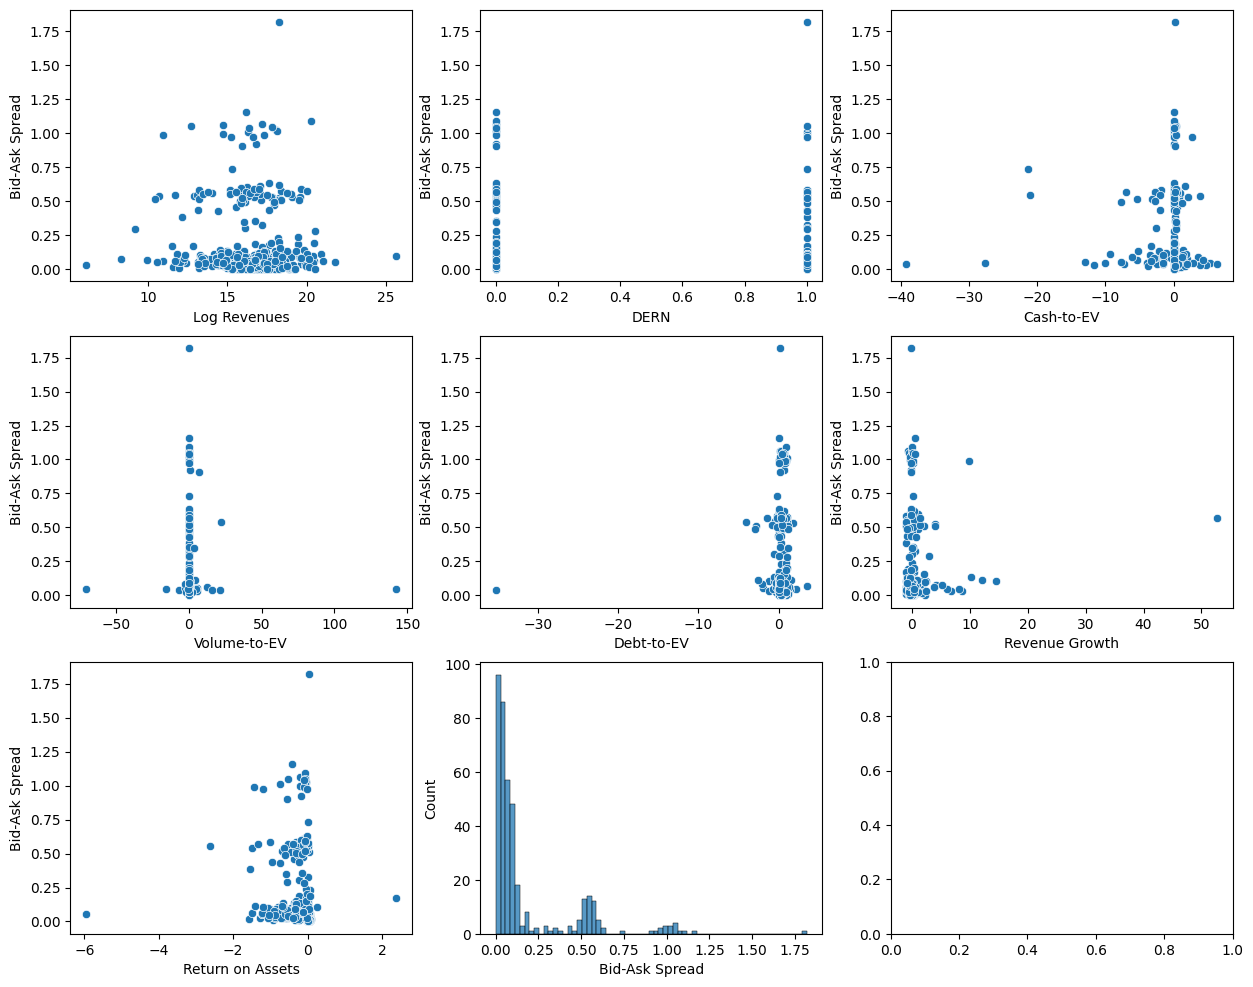

In [10]:
features_str = list(df.columns)
features_str.remove(Company.dependent_variable_name)
spread_col = Company.dependent_variable_name

# Plotting each variable against the bid-ask spread
ncols = 3
nrows = len(features_str) // ncols + 1

fig, ax = plt.subplots(nrows, ncols)
fig.set_size_inches(5 * ncols, 4 * nrows)
for i, feature in enumerate(features_str):
    sns.scatterplot(df[[feature, spread_col]], x=feature, y=spread_col, ax=ax[i//ncols][i%ncols])
sns.histplot(df[spread_col], ax=ax[len(features_str)//ncols][len(features_str)%ncols])

### Regression Analysis

In [11]:
train_df, test_df = train_test_split(df, test_size=0.2)
print(train_df.shape)
print(test_df.shape)

(320, 8)
(80, 8)


In [12]:
spread_col = Company.dependent_variable_name

X_train = train_df.loc[:, train_df.columns != spread_col]
y_train = train_df.loc[:, spread_col]
print(X_train.shape)
print(y_train.shape)

X_test = test_df.loc[:, test_df.columns != spread_col]
y_test = test_df.loc[:, spread_col]
print(X_test.shape)
print(y_test.shape)

(320, 7)
(320,)
(80, 7)
(80,)


For more information on why the $R^2$ value can be negative, refer to this [page](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination).

TL;DR: the scoring function is the coefficient of determination, calculated as:
\begin{align*}
    R^2(y, \hat{y}) = 1 - \frac{\sum^{n}_{i=1} (y_i - \hat{y_i})^2}{\sum^{n}_{i=1} (y_i - \bar{y})^2}
\end{align*}

So if the model performs *super, super* badly, then the sum of residuals in the numerator is greater than the denominator, making the R^2 score negative. Of course, you don't have to use this, and you can refer to the Excel figure instead. These models are a little iffy at times.

Fitting a model with Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression

model_linear = LinearRegression()
model_linear.fit(X_train, y_train)

# Calculating R^2 score
y_hat = model_linear.predict(X_test)
print('R^2 score on linear regression:', r2_score(y_test, y_hat))
print()
for i, feature in enumerate(model_linear.feature_names_in_):
    print(f"Coefficient on {feature:<15}: {model_linear.coef_[i]}")

R^2 score on linear regression: 0.05412258962604266

Coefficient on Log Revenues   : -0.011728778246699639
Coefficient on DERN           : -0.1242301260929162
Coefficient on Cash-to-EV     : -0.0055133448467016895
Coefficient on Volume-to-EV   : -0.0003278166224216071
Coefficient on Debt-to-EV     : 0.009749941644683228
Coefficient on Revenue Growth : 0.007136064272309105
Coefficient on Return on Assets: 0.006892522557285389


Fitting a model with LASSO Regression

In [14]:
from sklearn.linear_model import Lasso

model_lasso = Lasso(alpha=0.1)
model_lasso.fit(X_train, y_train)

# Calculating R^2 score
y_hat = model_lasso.predict(X_test)
print('R^2 score on LASSO regression:', r2_score(y_test, y_hat))
print()
for i, feature in enumerate(model_lasso.feature_names_in_):
    print(f"Coefficient on {feature:<15}: {model_lasso.coef_[i]}")

R^2 score on LASSO regression: -0.0006057990259633605

Coefficient on Log Revenues   : -0.0
Coefficient on DERN           : -0.0
Coefficient on Cash-to-EV     : -0.0
Coefficient on Volume-to-EV   : -0.0
Coefficient on Debt-to-EV     : 0.0
Coefficient on Revenue Growth : 0.0
Coefficient on Return on Assets: -0.0


Fitting a model with Decision Trees

R^2 score on Decision Tree regression: -0.5929667386132043


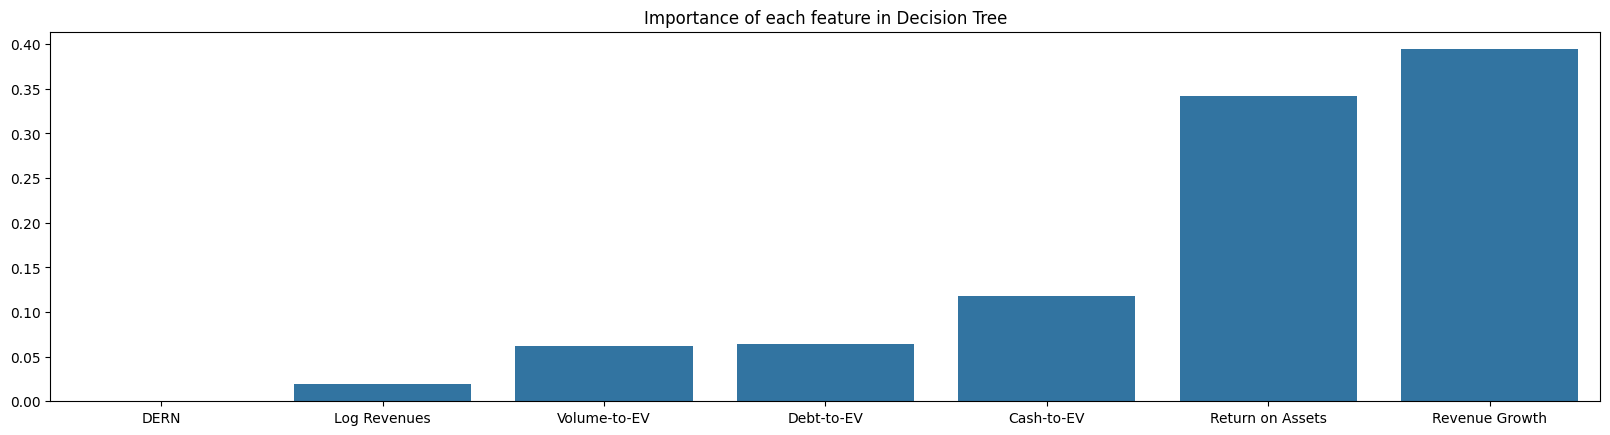

In [15]:
from sklearn.tree import DecisionTreeRegressor

model_forest = DecisionTreeRegressor(max_depth=5, min_samples_leaf=1)
model_forest.fit(X_train, y_train)

# Calculating R^2 score
print('R^2 score on Decision Tree regression:', model_forest.score(X_test, y_test))

importances = model_forest.feature_importances_

forest_importances = pd.Series(importances, index=model_forest.feature_names_in_)
forest_importances = forest_importances.sort_values(ascending=True)
forest_g = sns.barplot(forest_importances).set_title('Importance of each feature in Decision Tree')
forest_g.figure.set_figwidth(20)

Fitting a model with Support Vector Regression (using a Linear Kernel)

In [16]:
from sklearn.svm import LinearSVR

model_linear_svr = LinearSVR(tol=1e-5, max_iter=10000, C=100)
model_linear_svr.fit(X_train, y_train)

# Calculating R^2 score
print('R^2 score on Linear SVR:', model_linear_svr.score(X_test, y_test))

R^2 score on Linear SVR: -3.902315886276903


/home/planetastro/remotes/william-o-s/finance-algos/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting a model with Support Vector Regression (using a Polynomial Kernel)

In [17]:
from sklearn.svm import SVR

model_svr = SVR(kernel='poly', tol=1e-5, max_iter=10000, C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
model_svr.fit(X_train, y_train)

# Calculating R^2 score
print('R^2 score on RBF SVR:', model_svr.score(X_test, y_test))

R^2 score on RBF SVR: -2210.0049649970965


/home/planetastro/remotes/william-o-s/finance-algos/.venv/lib/python3.12/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
